# Import dependencies

In [2]:

import numpy as np
import scipy
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solveStateEquation import getSourceTerm, solveStateEquation, buildControlFunction
from src.solveAdjointEquation import solveAdjointEquation
from src.visualization import plot_array, printIterationInfo
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient, integrateVectorFunction, getIdxMax
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists

# Set parameters

In [3]:
@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    newton_c = 100
    eta = 0.01
    alpha = 1e-4
    beta = 1e-4
    waveSpeed = 1
    randomFactor = 0.00
    maxIterations = 20
    pruneThreshold = 1e-8
    yd = []
    adjoint_yd = []
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

# Setup problem

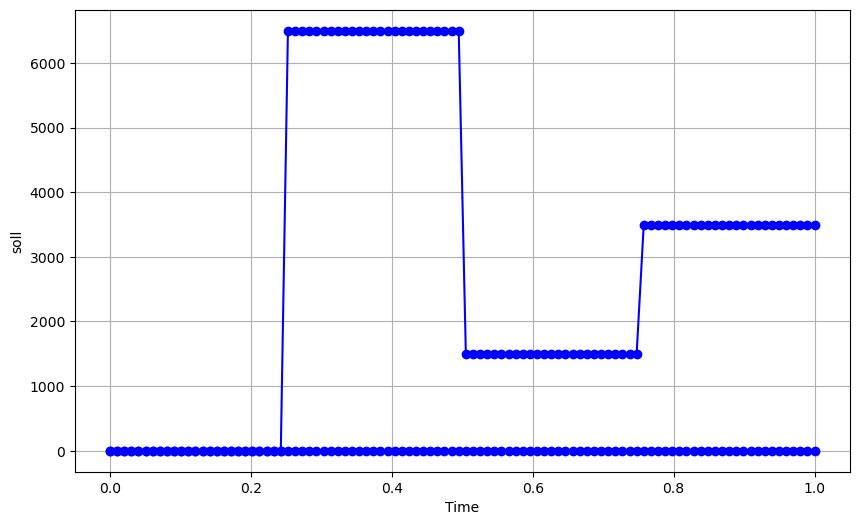

In [4]:
s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)) / params.alpha
s2 = lambda t : 0#0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275)) / params.alpha
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [s1, s2], params)
K_u = solveStateEquation(control, params)
grid_size = K_u[0].x.array.shape
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(params.V) for _ in K_u]
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + 0*np.random.normal(loc=0.0, scale=scale, size=grid_size)
params.yd = yd
params.adjoint_yd = solveAdjointEquation(params.yd, params)
discretInterval = np.linspace(0, params.T, int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in discretInterval])
array[:, 1] = np.array([s2(t) for t in discretInterval])
plot_array(array, params.T, label='soll')

# Minimization algorithm

In [5]:
active_set = []
timePoints = np.linspace(0, 1, num=int(params.T/params.dt) + 1)
hesse = HesseMatrix(active_set, params)
weights = np.ones(len(active_set))
slope = np.ones(params.d)
y_shift = np.ones(params.d)
constraintViolation = np.empty(params.maxIterations)
constraintViolation[:] = np.nan
print('Objective upper bound: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
weights, slope, y_shift = computeOSQPStep(weights, slope, y_shift, active_set, hesse, params)
print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
for k in range(params.maxIterations):
    printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
    u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse.standard_adjoints, params)
    p_k = scipy.integrate.cumulative_trapezoid(discreteDf, x=timePoints, initial=0)#integrateVectorFunction(discreteDf, params)
    P_k = -scipy.integrate.cumulative_trapezoid(p_k, x=timePoints, initial=0)#integrateVectorFunction(p_k, params)
    
    fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
    plot_array(discreteDf, params.T, label='grad', ax=ax1)
    plot_array(p_k, params.T, label='p_k', ax=ax2)
    plot_array(P_k, params.T, label='P_k', ax=ax3)
    plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function', ax=ax4)
    mpl.pyplot.show()
    
    idx_S = getIdxMax(p_k, active_set, type=0)
    idx_K = getIdxMax(P_k, active_set, type=1)
    norm_p_max = np.linalg.norm(p_k[idx_S])
    norm_P_max = np.linalg.norm(P_k[idx_K])
    
    print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
    constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
    if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
        break
    if norm_p_max / params.alpha >= norm_P_max / params.beta:
        active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
    else:
        active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))

    print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
    hesse.extendMatrix(active_set[-1])
    weights, slope, y_shift = computeOSQPStep(np.concatenate((weights, np.array([0.]))), slope, y_shift, active_set, hesse, params)
    print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
    active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
    hesse.pruneMatrix(active_set, weights)
    print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))

Objective upper bound:  5165.043666695034
weights:  [] slope:  [4411.10448901   64.17689847] y_shift [1223.69149793  -29.45856224]
Objective:  590.8589174866845
0 : Active set:
slope:  [4411.10448901   64.17689847] y_shift [1223.69149793  -29.45856224]
0 : Hesse condition: 72.93286783139075


ValueError: If given, length of x along axis must be the same as y.

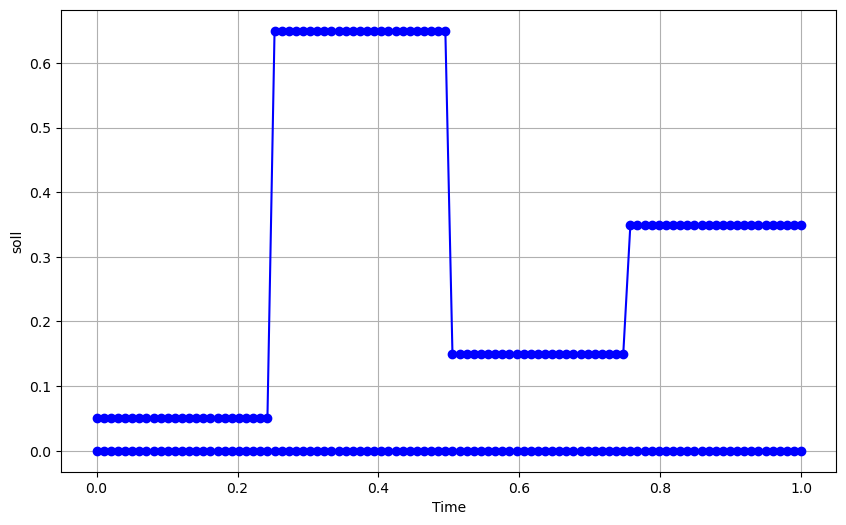

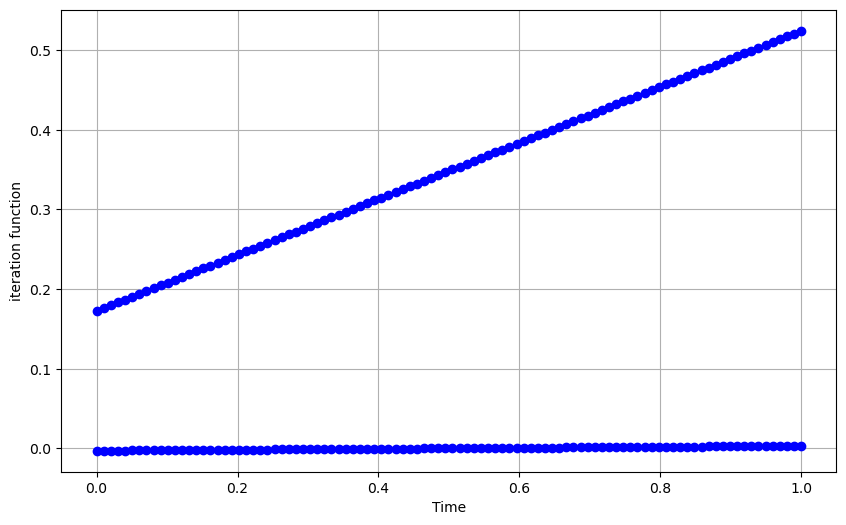

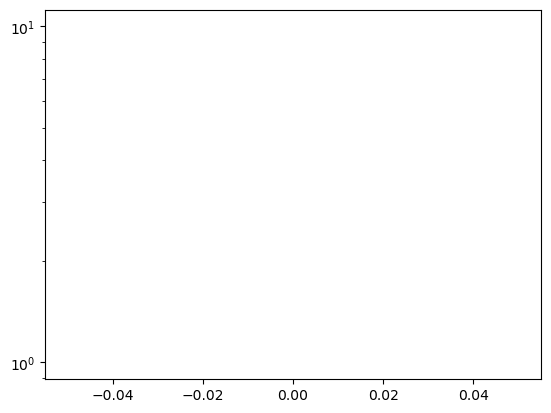

In [ ]:
plot_array(array, params.T, label='soll')
plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function')
#plot_array(constraintViolation, params.maxIterations, label='violation')

mpl.pyplot.yscale('log')
mpl.pyplot.plot(constraintViolation)